# Master Project - 1. Milestone

### Exploration of Bandit Algorithms

Author: Marvin Ernst

Date: February 11, 2025

##### Explaining the setup:

Usually what we would like to find is for the simple case, just which algorithm performs the best. In this setting we do not actually have algorithms (i.e. the arms), however, the arms still reperesnt choices one can make, where each of these arms is associated with a probability of success. It is a bandit problem (or specifically a multi-armed bandit problem), because we (the player) do not know a priori what these probabilities are. The goal is to learn which arm has the highest expected reward by experimenting with them. 

In our base implementation:

-	We have 5 arms (representing 5 different algorithms or choices).

-	Each arm has a true but hidden probability of giving a reward (this is its “quality”).

-	When an arm is pulled (chosen), the outcome is determined probabilistically.

-   We compare two policies, choosing an arm by random and by Thompson Sampling.

-  In the latest update I also added the Upper Confic´dence Bound (UCB) Algortihm



Importing relevant Libraries:

In [38]:
import numpy as np
import matplotlib.pyplot as plt

Set random seed for reproducibility:

In [39]:
np.random.seed(42)

### 1. A Multi-Armed Bandit environment


Initialize a multi-armed bandit problem with K arms.
Each arm has a fixed (but unknown) reward probability.


Simulate pulling an arm, returning a reward (1 with probability true_means[arm], otherwise 0).

In [ ]:
class MultiArmedBandit:
    def __init__(self, k=5):
        self.k = k  # Number of arms
        self.true_means = np.random.rand(k)  # True (unknown) reward probabilities
    
    def pull_arm(self, arm):
        return 1 if np.random.rand() < self.true_means[arm] else 0

### 2. Random policy for baseline comparison

Randomly select an arm.

In [ ]:
class RandomPolicy:
    def __init__(self, k):
        self.k = k
    
    def select_arm(self):
        return np.random.choice(self.k)

### 3. Thompson Sampling implementation

##### Definition:

Thompson Sampling (TS) is a Bayesian approach to the bandit problem. Instead of using simple statistical estimates, TS maintains a probabilistic belief over the reward of each arm and updates this belief over time.

**How it works:**

1. Initialize priors: 

    Each arm starts with a Beta distribution (Beta(1,1)), which represents our initial belief about the reward of each arm.

2.	Sampling step: At each round:

	-	We sample from the Beta distribution for each arm.

	-	We select the arm with the highest sampled value.

3.	Update step:

	-	If the selected arm gets a reward, we increase the success count.

	-	If it does not, we increase the failure count.

	-	This updates our belief about that arm’s effectiveness.


*Beta Distribution in Thompson Sampling:*

$\text{Beta}(\alpha_k, \beta_k)$

- $\alpha_k$ = number of successes for arm $k$  
- $\beta_k$ = number of failures for arm $k$  


In [ ]:
class ThompsonSampling:
    def __init__(self, k):
        self.k = k
        self.alpha = np.ones(k)  # Success counts
        self.beta = np.ones(k)   # Failure counts
    
    def select_arm(self):
        samples = [np.random.beta(self.alpha[i], self.beta[i]) for i in range(self.k)]
        return np.argmax(samples)
    
    def update(self, arm, reward): # herre we update the distribution based on observed reward
        self.alpha[arm] += reward
        self.beta[arm] += 1 - reward

### 4. Upper Confidence Bounds (UCB)

We implement the upper confidence bound algorithm. 

Select an arm based on the UCB strategy.

Then, we update estimates based on observed reward.

In [ ]:
class UCB:
    def __init__(self, k):
        self.k = k
        self.counts = np.zeros(k)  # Number of times each arm was selected
        self.values = np.zeros(k)  # Estimated value of each arm
    
    def select_arm(self, t):
        if 0 in self.counts:
            return np.argmin(self.counts)  # Play each arm at least once
        
        ucb_values = self.values + np.sqrt((2 * np.log(t)) / self.counts)
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

### 5. Simulation with regret tracking and visualization

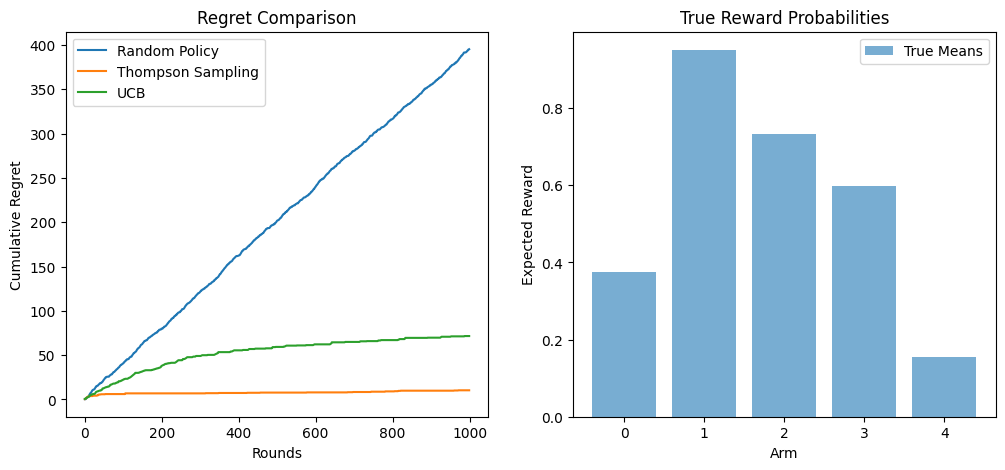

In [44]:
# Simulation parameters
k = 5  # Number of arms
n_rounds = 1000  # Number of pulls

# Initialize the bandit problem
bandit = MultiArmedBandit(k)
random_policy = RandomPolicy(k)
thompson_policy = ThompsonSampling(k)
ucb_policy = UCB(k)

# Track rewards and regret
random_rewards = []
thompson_rewards = []
ucb_rewards = []
optimal_reward = max(bandit.true_means)
random_regret = []
thompson_regret = []
ucb_regret = []

# Track arm selection counts
thompson_selections = np.zeros(k)
ucb_selections = np.zeros(k)

# Run simulation
for t in range(1, n_rounds + 1):
    # Random Policy
    rand_arm = random_policy.select_arm()
    rand_reward = bandit.pull_arm(rand_arm)
    random_rewards.append(rand_reward)
    random_regret.append(optimal_reward - bandit.true_means[rand_arm])
    
    # Thompson Sampling Policy
    thompson_arm = thompson_policy.select_arm()
    thompson_selections[thompson_arm] += 1
    thompson_reward = bandit.pull_arm(thompson_arm)
    thompson_policy.update(thompson_arm, thompson_reward)
    thompson_rewards.append(thompson_reward)
    thompson_regret.append(optimal_reward - bandit.true_means[thompson_arm])
    
    # UCB Policy
    ucb_arm = ucb_policy.select_arm(t)
    ucb_selections[ucb_arm] += 1
    ucb_reward = bandit.pull_arm(ucb_arm)
    ucb_policy.update(ucb_arm, ucb_reward)
    ucb_rewards.append(ucb_reward)
    ucb_regret.append(optimal_reward - bandit.true_means[ucb_arm])


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(random_regret), label='Random Policy')
plt.plot(np.cumsum(thompson_regret), label='Thompson Sampling')
plt.plot(np.cumsum(ucb_regret), label='UCB')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.title('Regret Comparison')

plt.subplot(1, 2, 2)
plt.bar(range(k), bandit.true_means, alpha=0.6, label='True Means')
plt.xlabel('Arm')
plt.ylabel('Expected Reward')
plt.title('True Reward Probabilities')
plt.legend()
plt.show()

#### First Plot:

Random Policy (blue line):

•	The regret grows linearly over time, meaning that this policy is not learning which arms are better.

•	It continues to select suboptimal arms at a high rate, leading to increasing cumulative regret.

Thompson Sampling (orange line):

•	The regret plateaus quickly, which means it learns which arm is best and starts exploiting it.

•	This shows that Thompson Sampling effectively reduces regret compared to random selection.

Since the Thompson Sampling policy has significantly lower cumulative regret, it confirms that this approach outperforms random selection, as theory predicts.

UCB behaves similar to thompson, however, it seem to do more round of exploration.


#### Second Plot: 

(Note, that the following results depend on the random seed you set.)

True Reward Probabilities (of each arm):

•	It looks like arms 1 and 2 have the highest expected rewards, meaning they are the “optimal” arms.

•	If the Thompson Sampling policy is working well, it should be selecting these arms more often over time.

#### Checking if Thompson Sampling and UCB favored arms with higher Expected Rewards

(Necessary parts have been added to the simulation loop.)

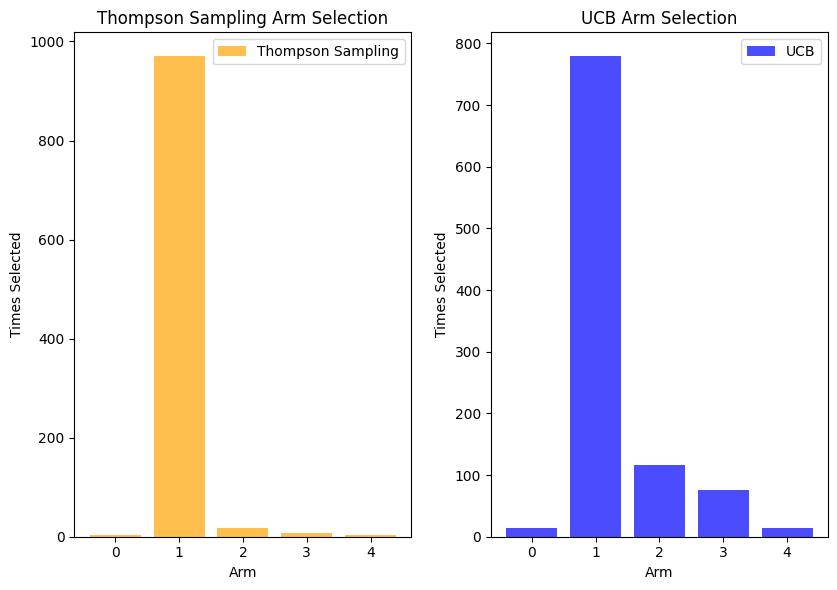

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 2)
plt.bar(range(k), thompson_selections, alpha=0.7, color='orange', label='Thompson Sampling')
plt.xlabel('Arm')
plt.ylabel('Times Selected')
plt.title('Thompson Sampling Arm Selection')
plt.legend()

plt.subplot(1, 3, 3)
plt.bar(range(k), ucb_selections, alpha=0.7, color='blue', label='UCB')
plt.xlabel('Arm')
plt.ylabel('Times Selected')
plt.title('UCB Arm Selection')
plt.legend()

plt.tight_layout()
plt.show()

Thompson sampling and UCB clearly favored the arm with the highest expected return. 

Thompson Sampling starts with a prior (Beta distribution) for each arm and updates it based on observed rewards. Over time, it has identified Arm 1 as the best and almost always selects it. The small number of selections for other arms suggests that TS explored briefly but quickly became confident that Arm 1 is optimal. This is expected behavior when one arm is significantly better than the others.

Upper Confidence Bound (UCB) selects arms based on their mean reward estimate plus an exploration bonus. UCB tends to explore more systematically than TS. Since we see more balance across arms, it indicates that UCB kept testing other arms longer before favoring Arm X. UCB’s exploration term decays more slowly than TS, so it keeps testing suboptimal arms more frequently than TS.